In [0]:
#2.4.5 version 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as psf
from pyspark.sql.functions import *
from pyspark.sql.functions import col, column
import re
import pandas as pd
from pyspark.sql.functions import desc, asc


In [0]:
# spark = SparkSession.builder.master("local[*]").getOrCreate()
MAX_MEMORY = '12g'

spark = SparkSession\
        .builder\
        .appName('Venmo')\
        .config("spark.executor.memory", MAX_MEMORY) \
        .config("spark.driver.memory", MAX_MEMORY) \
        .getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/Shared\ drives/
directory=os.getcwd()
directory=directory+"/BAX-423 Big Data Analytics/Final Project/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/Shared drives


#### whole dataset

In [0]:
sample_data=spark.read.parquet(directory+"VenmoSample.snappy.parquet")

#### start

transfer the dataset into user 1 as the spender

In [6]:
transaction_spent = sample_data.select('user1','user2','datetime','description','is_business','story_id').where(col('transaction_type')=='payment')\
                    .union(sample_data.select('user2','user1','datetime','description','is_business','story_id').where(col('transaction_type')=='charge'))
transaction_spent.show()

+--------+-------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|           datetime|         description|is_business|            story_id|
+--------+-------+-------------------+--------------------+-----------+--------------------+
| 1218774|1528945|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|
| 5109483|4782303|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|
| 4322148|3392963|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|
| 2960727|3442373|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|
| 3977544|2709470|2016-09-29 22:12:07|          Chipotlaid|      false|57ed2f4723e064eac...|
| 3766386|4209061|2016-05-20 10:31:15|     kitchen counter|      false|573e8503cd03c9af2...|
|  730075| 804466|2016-05-26 04:46:45|                Food|      false|57461d46cd03c9af2...|
| 5221751|4993533|2016-07-14 22:53:49|               Zaxby|      false

### read dictionary 

In [0]:
 emoji_dict= spark.read.load(directory+"Venmo_Emoji_Classification_Dictionary.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [0]:
word_dict= spark.read.load(directory+"Venmo Word Classification Dictonary.csv",
                     format="csv", sep=",", inferSchema="true", header="true")\
.withColumnRenamed("People ", "People")\
.withColumnRenamed("Food ", "Food")\
.withColumnRenamed("Event ", "Event")\
.withColumnRenamed('Activity ',"Activity")\
.withColumnRenamed('Travel ',"Travel")\
.withColumnRenamed('Transportation ',"Transportation")\
.withColumnRenamed('Utility ',"Utility")\
.withColumnRenamed('Cash',"Cash")\
.withColumnRenamed('Illegal/Sarcasm ',"Illegal")

In [0]:
#union
emoji_word_dict=emoji_dict.withColumn("Cash",lit(None))\
.withColumn("Illegal",lit(None))\
.unionByName(word_dict)

### Q1
Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset.

Tokenize


In [0]:
from pyspark.ml.feature import Tokenizer
tkn = Tokenizer().setInputCol("description").setOutputCol("DescOut")
tokenized = tkn.transform(transaction_spent.select(expr("*")))

To split emoji and words with has no space in between such as Bdayyy🎉💞🎉

In [12]:
colsSplitWordEmoji = udf(lambda z: split_word_emoji(z))
spark.udf.register("colsSplitWordEmoji", colsSplitWordEmoji)

def split_word_emoji(col):
  splited_word_emoji_list=[]
  for x in col:
    pp=re.findall("(\w+|[^\w ]+)",x)
    for el in pp:
      splited_word_emoji_list.append(el)
  return splited_word_emoji_list
tokenized_plus=tokenized.withColumn('DescOut',colsSplitWordEmoji("DescOut"))
tokenized_plus.show(5)

+-------+-------+-------------------+------------+-----------+--------------------+---------------+
|  user1|  user2|           datetime| description|is_business|            story_id|        DescOut|
+-------+-------+-------------------+------------+-----------+--------------------+---------------+
|1218774|1528945|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|         [uber]|
|5109483|4782303|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|       [costco]|
|4322148|3392963|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|[sweaty, balls]|
|2960727|3442373|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|            [⚡]|
|3977544|2709470|2016-09-29 22:12:07|  Chipotlaid|      false|57ed2f4723e064eac...|   [chipotlaid]|
+-------+-------+-------------------+------------+-----------+--------------------+---------------+
only showing top 5 rows



In [13]:
tokenized_explode=tokenized_plus.withColumn("exploded",split(col("DescOut"),","))\
          .withColumn("exploded",explode(col("exploded")))\
          .withColumn("exploded",translate("exploded","[]","")) #get rid of []
tokenized_explode.show(5)

+-------+-------+-------------------+------------+-----------+--------------------+---------------+--------+
|  user1|  user2|           datetime| description|is_business|            story_id|        DescOut|exploded|
+-------+-------+-------------------+------------+-----------+--------------------+---------------+--------+
|1218774|1528945|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|         [uber]|    uber|
|5109483|4782303|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|       [costco]|  costco|
|4322148|3392963|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|[sweaty, balls]|  sweaty|
|4322148|3392963|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|[sweaty, balls]|   balls|
|2960727|3442373|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|            [⚡]|       ⚡|
+-------+-------+-------------------+------------+-----------+--------------------+---------------+--------+
only showing top 5 

split emoji


In [14]:
##emoji format can be \\u270c or \\U00001F680
colsEmojiSplit = udf(lambda z: split_emoji(z))
spark.udf.register("colsEmojiSplit", colsEmojiSplit)

def split_emoji(col):
  splited_emoji_list=re.findall('\\\\[Uu][0-9a-zA-Z]+',col.strip().encode('unicode-escape').decode('utf-8'))
  if splited_emoji_list==[]:
    splited_emoji_list_decoded=col
  else:
    splited_emoji_list_decoded=[x.encode('utf-8').decode('unicode-escape') for x in splited_emoji_list]
  return splited_emoji_list_decoded
  
tokenized_explode_plus=tokenized_explode.withColumn('exploded',colsEmojiSplit("exploded"))\
          .withColumn("exploded",translate("exploded","[]",""))\
          .withColumn("exploded",split(col("exploded"),","))\
          .withColumn("exploded",explode(col("exploded")))\
          .withColumn("exploded",trim(col("exploded")))
tokenized_explode_plus.show(200)

+--------+-------+-------------------+--------------------+-----------+--------------------+--------------------+------------+
|   user1|  user2|           datetime|         description|is_business|            story_id|             DescOut|    exploded|
+--------+-------+-------------------+--------------------+-----------+--------------------+--------------------+------------+
| 1218774|1528945|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|              [uber]|        uber|
| 5109483|4782303|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|            [costco]|      costco|
| 4322148|3392963|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|     [sweaty, balls]|      sweaty|
| 4322148|3392963|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|     [sweaty, balls]|       balls|
| 2960727|3442373|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|                 [⚡

tag the appearance of emoji and word

In [15]:
emoji_word_classified=tokenized_explode_plus
for h in ['People','Food','Event','Activity','Travel','Transportation','Utility','Cash','Illegal']:
  JoinExpression=emoji_word_classified['exploded']==emoji_word_dict[h]
  emoji_word_classified=emoji_word_classified.join(emoji_word_dict.select(col(h)).na.drop(), JoinExpression , 'left_outer')\
                .withColumn(h,when(col(h).isNull(),0).otherwise(1))
 
emoji_word_classified.show(50)

+--------+-------+-------------------+--------------------+-----------+--------------------+--------------------+----------+------+----+-----+--------+------+--------------+-------+----+-------+
|   user1|  user2|           datetime|         description|is_business|            story_id|             DescOut|  exploded|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal|
+--------+-------+-------------------+--------------------+-----------+--------------------+--------------------+----------+------+----+-----+--------+------+--------------+-------+----+-------+
| 1218774|1528945|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|              [uber]|      uber|     0|   0|    0|       0|     0|             1|      0|   0|      0|
| 5109483|4782303|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|            [costco]|    costco|     0|   1|    0|       0|     0|             0|      0|   0|      0|
| 4322148|3392963|2015-06

group by to unexplode

In [16]:

Venmo_summary=emoji_word_classified.drop("exploded").groupby(['user1','user2','datetime','description','is_business','story_id'])\
.agg(expr("sum(People) as People" ),expr("sum(Food) as Food"),expr("sum(Event) as Event"),expr("sum(Activity) as Activity"),expr("sum(Travel) as Travel"),expr("sum(Transportation) as Transportation"),expr("sum(Utility) as Utility"),expr("sum(Cash) as Cash"),expr("sum(Illegal) as Illegal"))
Venmo_summary.cache()
Venmo_summary.show(200)

+--------+--------+-------------------+--------------------+-----------+--------------------+------+----+-----+--------+------+--------------+-------+----+-------+
|   user1|   user2|           datetime|         description|is_business|            story_id|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal|
+--------+--------+-------------------+--------------------+-----------+--------------------+------+----+-----+--------+------+--------------+-------+----+-------+
| 5985976| 1672336|2016-09-07 03:28:48|                Tits|      false|57cf270023e064eac...|     0|   0|    0|       0|     0|             0|      0|   0|      0|
| 4224355| 1426485|2015-06-03 12:37:43|                Vons|      false|556e92a7583c04677...|     0|   0|    0|       0|     0|             0|      0|   0|      0|
|  238099|  242275|2016-07-24 15:08:57|      We shoulda won|      false|5794779923e064eac...|     0|   0|    0|       0|     0|             0|      0|   0|      0|
| 1991048| 20290

## Q2

In [0]:
# split emoji list for emoji-only tagging
emoji_list_people=emoji_dict.select("People").na.drop()\
          .rdd.map(lambda row : row[0]).collect()
emoji_list_food=emoji_dict.select("Food").na.drop()\
          .rdd.map(lambda row : row[0]).collect()
emoji_list_event=emoji_dict.select("Event").na.drop()\
          .rdd.map(lambda row : row[0]).collect()
emoji_list_activity=emoji_dict.select("Activity").na.drop()\
          .rdd.map(lambda row : row[0]).collect() 
emoji_list_travel=emoji_dict.select("Travel").na.drop()\
          .rdd.map(lambda row : row[0]).collect()
emoji_list_transportation=emoji_dict.select("Transportation").na.drop()\
          .rdd.map(lambda row : row[0]).collect() 
emoji_list_utility=emoji_dict.select("Utility").na.drop()\
          .rdd.map(lambda row : row[0]).collect()



#### What is the percent of emoji only transactions?

In [17]:
emoji_search=tokenized_explode_plus
for h in ['People','Food','Event','Activity','Travel','Transportation','Utility']:
  a=0
  emoji_list_name='emoji_list_'+h.lower()
  emoji_search=emoji_search.withColumn(
        h,psf.regexp_extract("exploded", '(?=|\s)(' + '|'.join(vars()[emoji_list_name]) + ')(?=\s|)', 0)
  )\
    .withColumn(h,psf.when(col(h)=='', '0').otherwise(1))
emoji_search.show(50)

+--------+-------+-------------------+--------------------+-----------+--------------------+--------------------+----------+------+----+-----+--------+------+--------------+-------+
|   user1|  user2|           datetime|         description|is_business|            story_id|             DescOut|  exploded|People|Food|Event|Activity|Travel|Transportation|Utility|
+--------+-------+-------------------+--------------------+-----------+--------------------+--------------------+----------+------+----+-----+--------+------+--------------+-------+
| 1218774|1528945|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|              [uber]|      uber|     0|   0|    0|       0|     0|             0|      0|
| 5109483|4782303|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|            [costco]|    costco|     0|   0|    0|       0|     0|             0|      0|
| 4322148|3392963|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a..

In [0]:
Venmo_emoji_only_summary=emoji_search.drop("exploded")\
.withColumn("result", expr('+'.join(['People','Food','Event','Activity','Travel','Transportation','Utility'])))\
.groupby(['user1','user2','datetime','description','is_business','story_id'])\
.agg(expr("min(result) as Result" ))


In [19]:
Venmo_emoji_only_summary.where("result>0").count()/Venmo_emoji_only_summary.count()

0.15134068133370693

#### Which are the top 5 most popular emoji?

In [20]:
emoji_search.show(5)

+-------+-------+-------------------+------------+-----------+--------------------+---------------+--------+------+----+-----+--------+------+--------------+-------+
|  user1|  user2|           datetime| description|is_business|            story_id|        DescOut|exploded|People|Food|Event|Activity|Travel|Transportation|Utility|
+-------+-------+-------------------+------------+-----------+--------------------+---------------+--------+------+----+-----+--------+------+--------------+-------+
|1218774|1528945|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|         [uber]|    uber|     0|   0|    0|       0|     0|             0|      0|
|5109483|4782303|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|       [costco]|  costco|     0|   0|    0|       0|     0|             0|      0|
|4322148|3392963|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|[sweaty, balls]|  sweaty|     0|   0|    0|       0|     0|             0|      0|
|432

In [21]:
Venmo_emoji_summary=emoji_search.withColumn("result", expr('+'.join(['People','Food','Event','Activity','Travel','Transportation','Utility'])))\
.where("result>0")\
.select("exploded")\
.groupby('exploded').count().orderBy(col("count").desc()).limit(5)

Venmo_emoji_summary.show(200)

+--------+------+
|exploded| count|
+--------+------+
|      🍕|215039|
|      🍻|145233|
|      🍷|111157|
|      🎉| 94327|
|      🍺| 85710|
+--------+------+



#### Which are the top three most popular emoji categories?

In [74]:
emoji_search.select(expr("sum(People) as People" ),expr("sum(Food) as Food"),expr("sum(Event) as Event"),\
                    expr("sum(Activity) as Activity"),expr("sum(Travel) as Travel"),expr("sum(Transportation) as Transportation"),\
                    expr("sum(Utility) as Utility")).show()

+---------+---------+--------+--------+--------+--------------+--------+
|   People|     Food|   Event|Activity|  Travel|Transportation| Utility|
+---------+---------+--------+--------+--------+--------------+--------+
|1011889.0|1744390.0|163141.0|423988.0|111848.0|      258830.0|301868.0|
+---------+---------+--------+--------+--------+--------------+--------+



## Q3 
For each user, create a variable to indicate their spending behavior profile. 


In [23]:
Venmo_summary_by_user=Venmo_summary.repartition('user1')\
.withColumn("result", expr('+'.join(['People','Food','Event','Activity','Travel','Transportation','Utility','Cash','Illegal'])))\
.groupby(['user1'])\
.agg(expr("sum(People)/sum(result) as People" ),expr("sum(Food)/sum(result) as Food"),expr("sum(Event)/sum(result) as Event"),\
     expr("sum(Activity)/sum(result) as Activity"),expr("sum(Travel)/sum(result) as Travel"),expr("sum(Transportation)/sum(result) as Transportation"),\
     expr("sum(Utility)/sum(result) as Utility"),expr("sum(Cash)/sum(result) as Cash"),expr("sum(Illegal)/sum(result) as Illegal"),\
     expr("sum(result) as total"))\
.na.fill(0)\
.drop("total")
Venmo_summary_by_user.show()

+-------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|  user1|             People|                Food|               Event|           Activity|              Travel|      Transportation|             Utility|               Cash|             Illegal|
+-------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|1023874|                0.5|                 0.5|                 0.0|                0.0|                 0.0|                 0.0|                 0.0|                0.0|                 0.0|
|1081822|0.14285714285714285| 0.14285714285714285|  0.5714285714285714|0.14285714285714285|                 0.0|                 0.0|                 0.0|                0.0|                 0.0|
| 180155|0.142857142

## Q4

In [0]:
startdate = transaction_spent.select('user1','datetime')\
                  .groupby('user1')\
                  .agg(min('datetime').alias('start_datetime'))\
                  .orderBy('start_datetime')
                                

In [0]:
transaction_spent.createOrReplaceTempView("transaction_spent")
user_all_lifepoint = spark.sql("""
SELECT
*
FROM(
select DISTINCT user1, 0 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 1 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 2 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 3 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 4 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 5 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 6 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 7 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 8 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 9 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 10 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 11 as lifepoint
from transaction_spent
Union
select DISTINCT user1, 12 as lifepoint
from transaction_spent
)a
ORDER BY user1,lifepoint
""")
user_all_lifepoint.createOrReplaceTempView("user_all_lifepoint")

In [0]:
Venmo_summary_by_user_by_time=Venmo_summary.repartition('user1')\
                      .join(startdate, Venmo_summary.user1==startdate.user1)\
                         .drop(startdate.user1)\
                         .withColumn("lifetime", ceil(datediff(Venmo_summary.datetime, startdate.start_datetime)/30))\
.withColumn("result", expr('+'.join(['People','Food','Event','Activity','Travel','Transportation','Utility'])))\
.groupby(['user1','lifetime'])\
.agg(expr("sum(People) as People" ),expr("sum(Food) as Food"),expr("sum(Event) as Event"),\
     expr("sum(Activity) as Activity"),expr("sum(Travel) as Travel"),expr("sum(Transportation) as Transportation"),\
     expr("sum(Utility) as Utility"),expr("sum(Cash) as Cash"),expr("sum(Illegal) as Illegal"),\
     expr("sum(result) as total"))

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc
windowSpec = Window\
.partitionBy("user1")\
.orderBy("lifetime")\
.rowsBetween(Window.unboundedPreceding, Window.currentRow)

In [59]:
Venmo_summary_by_user_by_time.show(50)

+-----+--------+------+----+-----+--------+------+--------------+-------+----+-------+-----+
|user1|lifetime|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal|total|
+-----+--------+------+----+-----+--------+------+--------------+-------+----+-------+-----+
| 2866|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
| 6620|       0|     0|   0|    0|       0|     1|             0|      0|   0|      0|    1|
| 6620|      16|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|20735|       0|     0|   3|    0|       1|     0|             0|      0|   0|      0|    4|
|28170|      48|     0|   0|    0|       0|     0|             0|      5|   0|      0|    5|
|28170|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|28759|       0|     0|   0|    0|       0|     0|             0|      1|   0|      0|    1|
|28759|       6|     0|   0|    0|       0|     0|             1|     

### add lifepoint


In [0]:
user_all_lifepoint_tagged=user_all_lifepoint.join(Venmo_summary_by_user_by_time.alias("l"),(user_all_lifepoint['user1']==Venmo_summary_by_user_by_time['user1'])&(user_all_lifepoint['lifepoint']==Venmo_summary_by_user_by_time['lifetime']),'left')\
.drop(col('l.user1')).orderBy("user1","lifepoint").na.fill(0)

In [58]:
user_all_lifepoint_tagged.show(10)

+-----+---------+--------+------+----+-----+--------+------+--------------+-------+----+-------+-----+
|user1|lifepoint|lifetime|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal|total|
+-----+---------+--------+------+----+-----+--------+------+--------------+-------+----+-------+-----+
|    2|        0|       0|     0|   0|    0|       0|     0|             0|      1|   0|      0|    1|
|    2|        1|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|    2|        2|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|    2|        3|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|    2|        4|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|    2|        5|       0|     0|   0|    0|       0|     0|             0|      0|   0|      0|    0|
|    2|        6|       0|     0|   0|    0|       0|     0|             

Roling sum using windows functioin and percentage

In [0]:
# from pyspark.sql.functions import max
SumPeople = sum(col("People")).over(windowSpec)
SumFood = sum(col("Food")).over(windowSpec)
SumEvent = sum(col("Event")).over(windowSpec)
SumActivity = sum(col("Activity")).over(windowSpec)
SumTravel = sum(col("Travel")).over(windowSpec)
SumTransportation = sum(col("Transportation")).over(windowSpec)
SumUtility = sum(col("Utility")).over(windowSpec)
SumCash = sum(col("Cash")).over(windowSpec)
SumIllegal = sum(col("Illegal")).over(windowSpec)

maxresult = sum(col("total")).over(windowSpec)
Venmo_summary_by_user_by_lifetime=user_all_lifepoint_tagged.repartition(col('user1'))\
                         .select(col("user1"),col("lifepoint"),(SumPeople/maxresult).alias("People"),(SumFood/maxresult).alias("Food"),\
                                 (SumEvent/maxresult).alias("Event"),(SumActivity/maxresult).alias("Activity"),(SumTravel/maxresult).alias("Travel"),\
                                 (SumTransportation/maxresult).alias("Transportation"),(SumUtility/maxresult).alias("Utility"),(SumCash/maxresult).alias("Cash"),\
                                 (SumIllegal/maxresult).alias("Illegal"),\
                                 maxresult.alias("Total"))\
                         .na.fill(0)

In [0]:
lifetime_avg=Venmo_summary_by_user_by_lifetime.groupby(['lifepoint'])\
.agg(expr("avg(People) as People" ),expr("avg(Food) as Food"),expr("avg(Event) as Event"),\
     expr("avg(Activity) as Activity"),expr("avg(Travel) as Travel"),expr("avg(Transportation) as Transportation"),\
     expr("avg(Utility) as Utility"),expr("avg(Cash) as Cash"),expr("avg(Illegal) as Illegal"))

In [0]:
lifetime_avg.createOrReplaceTempView("lifetime_avg")
lifetime_avg_sql_pd=spark.sql("SELECT lifepoint,stack(9,'People',People,'Food',Food,'Event',Event,'Activity',Activity,'Travel',Travel,'Transportation',Transportation,\
'Utility',Utility,'Cash',Cash,'Illegal',Illegal) as (Category, percentage) from lifetime_avg")\
.toPandas()

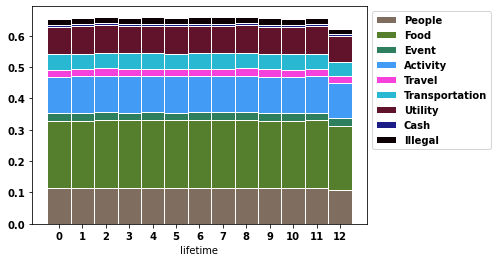

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='People']['percentage'].tolist()
bars2 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Food']['percentage'].tolist()
bars3 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Event']['percentage'].tolist()
bars4 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Activity']['percentage'].tolist()
bars5 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Travel']['percentage'].tolist()
bars6 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Transportation']['percentage'].tolist()
bars7 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Utility']['percentage'].tolist()
bars8 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Cash']['percentage'].tolist()
bars9 = lifetime_avg_sql_pd[lifetime_avg_sql_pd.Category=='Illegal']['percentage'].tolist()

# Heights of bars
bars12 = np.add(bars1, bars2).tolist()
bars23 = np.add(bars12,bars3).tolist()
bars34 = np.add(bars23,bars4).tolist()
bars45 = np.add(bars34, bars5).tolist()
bars56 = np.add(bars45,bars6).tolist()
bars67 = np.add(bars56,bars7).tolist()
bars78 = np.add(bars67,bars8).tolist()
bars89 = np.add(bars78,bars9).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9,10,11,12]
 
# Names of group and bar width
names = r
barWidth = 1
 
# Create brown bars
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth, label="People")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#567f2d', edgecolor='white', width=barWidth, label="Food")
# Create green bars (top)
plt.bar(r, bars3, bottom=bars12, color='#2d7f5e', edgecolor='white', width=barWidth, label="Event")
plt.bar(r, bars4, bottom=bars23, color='#429bf5', edgecolor='white', width=barWidth, label="Activity")
plt.bar(r, bars5, bottom=bars34, color='#f542dd', edgecolor='white', width=barWidth, label="Travel")
plt.bar(r, bars6, bottom=bars45, color='#28b8d1', edgecolor='white', width=barWidth, label="Transportation")
plt.bar(r, bars7, bottom=bars56, color='#61132b', edgecolor='white', width=barWidth, label="Utility")
plt.bar(r, bars8, bottom=bars67, color='#1c1c87', edgecolor='white', width=barWidth, label="Cash")
plt.bar(r, bars9, bottom=bars78, color='#0d0004', edgecolor='white', width=barWidth, label="Illegal")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("lifetime")
plt.yticks
# Show graphic
plt.show()